## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [112]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [113]:
train = np.loadtxt('C:/temp/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('C:/temp/digit/test.csv', delimiter=',', skiprows=1)

In [114]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

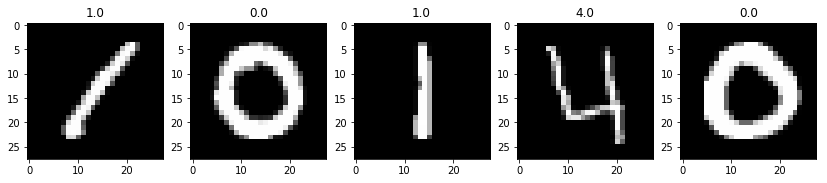

In [115]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [116]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [117]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [118]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [119]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

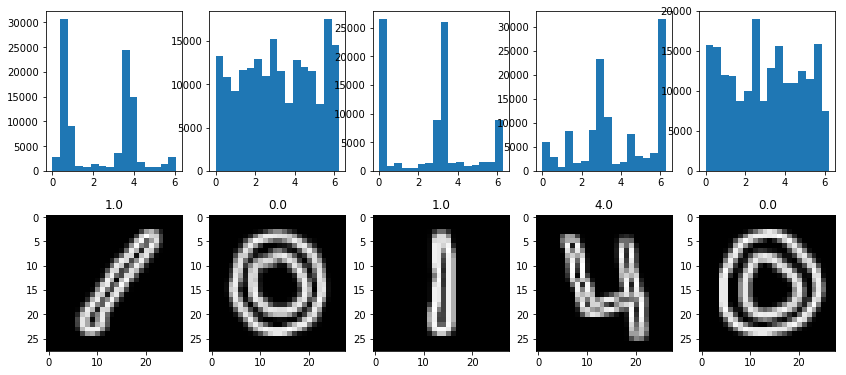

In [120]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [137]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [138]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Сдвигаем гистограммы так, чтобы максимальное значение тояло на первой позиции

In [140]:
for i in range(len(train_hist)):
    max_h = np.argmax( train_hist[i])
    train_hist[i] =  np.concatenate( (train_hist[i][max_h:len(train_hist[i])], train_hist[i][0:max_h]), axis=0)

In [141]:
for i in range(len(test_hist)):
    max_h = np.argmax( test_hist[i])
    test_hist[i] =  np.concatenate( (test_hist[i][max_h:len(test_hist[i])], test_hist[i][0:max_h]), axis=0)

## Нормируем вектор гистограммы

In [142]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [143]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Проверим точность метода только на числе 5

In [158]:
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import make_scorer

kfold = KFold(n_splits=4, shuffle=True, random_state=145)

Создадим ответы  только для числа 5

In [159]:
train_label

array([ 1.,  0.,  1., ...,  7.,  6.,  9.])

In [160]:
train_label_5 = train_label.copy()
i = 0
while i < len( train_label_5):
    train_label_5[i] = 1 if train_label_5[i] == 5 else 0
    i +=1
train_label_5

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [161]:
#pipeline = Pipeline(steps=[('scale', StandardScaler()),
#                           ('model', Ridge(alpha=1.0))])
#
#param_grid = {'model': [Ridge(alpha=1.5),
#                        RandomForestRegressor(),
#                        GradientBoostingRegressor(),
#                        BaggingRegressor()]}
#
#grid_5 = GridSearchCV(pipeline, param_grid, 
#                    scoring=make_scorer(r2_score),
#                    cv=kfold)
#model_5 = grid_5.fit(train_hist, train_label_5)
#model_5.cv_results_['mean_test_score']

In [163]:
model_5 = GradientBoostingRegressor().fit(train_hist, train_label_5)

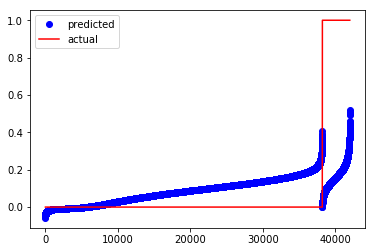

In [164]:
#predicted_5 = model_5.best_estimator_.predict(train_hist)
predicted_5 = model_5.predict(train_hist)

pairs = np.array(sorted(zip(train_label_5, predicted_5)))
plt.plot(range(0, len(pairs)), pairs[:, 1], 'bo',
         range(0, len(pairs)), pairs[:, 0], 'r-')

plt.legend(['predicted', 'actual'])
plt.show()

In [165]:
error = 0
i = 0
p = 0.2
while i < len( predicted_5):
    error += 1 if train_label_5[i] == 0 and predicted_5[i] > p or train_label_5[i] == 1 and predicted_5[i] <= p else 0
    i +=1
error / len( predicted_5)

0.09795238095238096

## Строим гибридную модель

In [166]:
y = []
for i in range(10):
    y_i = train_label.copy()
    j = 0
    for j in range(len( y_i)):
        y_i[j] = 1 if y_i[j] == i else 0
    y.append(y_i)
y

[array([ 0.,  1.,  0., ...,  0.,  0.,  0.]),
 array([ 1.,  0.,  1., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  1.,  0.]),
 array([ 0.,  0.,  0., ...,  1.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  1.])]

In [167]:
#model = []
#for i in range(10):
#    pipeline = Pipeline(steps=[('scale', StandardScaler()),
#                           ('model', Ridge(alpha=1.0))])
#    param_grid = {'model': [Ridge(alpha=1.5),
#                        RandomForestRegressor(),
#                        GradientBoostingRegressor(),
#                        BaggingRegressor()]}
#    grid = GridSearchCV(pipeline, param_grid, 
#                    scoring=make_scorer(r2_score),
#                    cv=kfold)
#    model.append( grid.fit(train_hist, y[i]))
#    print("complite: ", i)
#    print( model[i].cv_results_['mean_test_score'])

In [168]:
model = []
for i in range(10):
    model.append( GradientBoostingRegressor())
    model[i].fit(train_hist, y[i])
    print("complite: ", i)

complite:  0
complite:  1
complite:  2
complite:  3
complite:  4
complite:  5
complite:  6
complite:  7
complite:  8
complite:  9


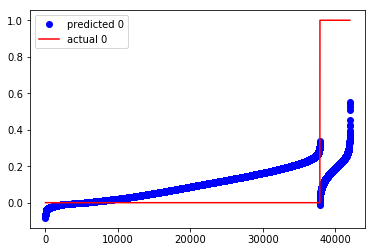

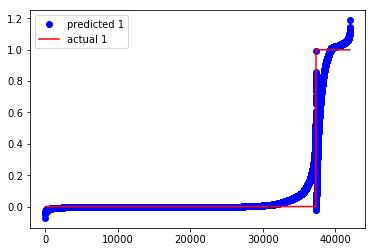

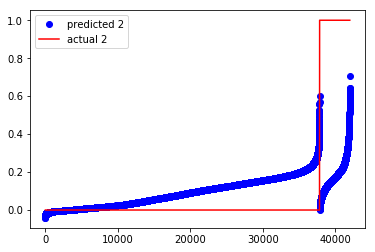

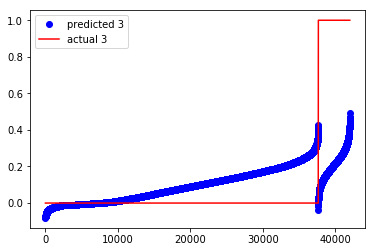

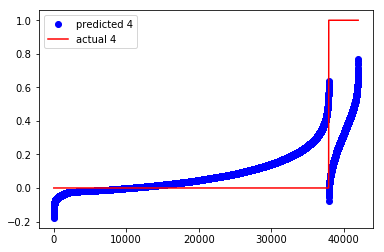

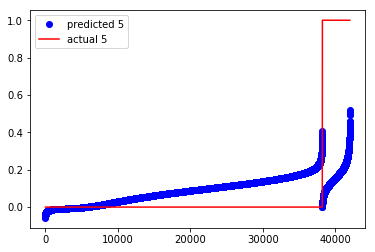

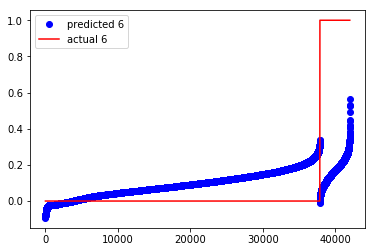

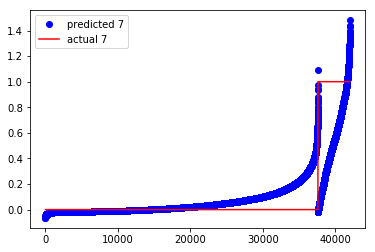

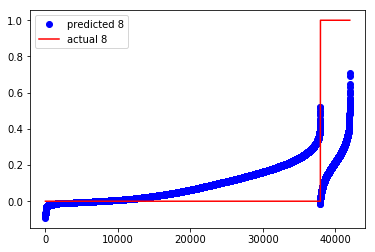

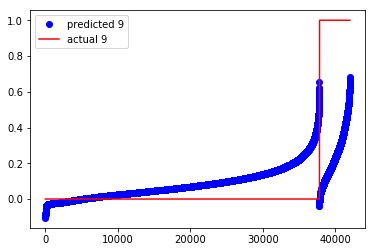

In [169]:
for i in range(10):
    #predicted = model[i].best_estimator_.predict(train_hist)
    predicted = model[i].predict(train_hist)
    pairs = np.array(sorted(zip(y[i], predicted)))
    plt.plot(range(0, len(pairs)), pairs[:, 1], 'bo',
         range(0, len(pairs)), pairs[:, 0], 'r-')
    plt.legend(['predicted ' + str(i), 'actual ' + str(i)])
    plt.show()

## Вычисляем результат

In [170]:
import math

In [171]:
predicted_test_dif = []
for i in range(10):
    #predicted_test_dif.append( model[i].best_estimator_.predict(test_hist))
    predicted_test_dif.append( model[i].predict(test_hist))
    print("complite: ", i)
    print( predicted_test_dif[i])

complite:  0
[ 0.11301774  0.1121152   0.01125647 ...,  0.15201579  0.09965881
  0.12552223]
complite:  1
[-0.00229476 -0.00103918  0.01806965 ..., -0.00126424  0.00591841
 -0.00212386]
complite:  2
[ 0.12702558  0.15508462  0.01546684 ...,  0.1059475   0.07687726
  0.22240557]
complite:  3
[ 0.12102638  0.31179239  0.00552043 ...,  0.2958549   0.01073473
  0.17161904]
complite:  4
[ 0.01501831  0.02257362  0.25234665 ..., -0.01787927  0.15723114
 -0.02086047]
complite:  5
[ 0.12819171  0.13517302 -0.0062687  ...,  0.18139172  0.05507802
  0.09868397]
complite:  6
[ 0.08735768  0.05302568  0.16746839 ...,  0.15033306  0.17027247
  0.04140945]
complite:  7
[-0.01802202  0.02963495  0.09285178 ..., -0.01912511  0.09131793
 -0.01483477]
complite:  8
[ 0.2354856   0.23681954 -0.00952161 ...,  0.17195719  0.01475294
  0.27862292]
complite:  9
[  1.84393862e-01   2.36858871e-02   4.36076463e-01 ...,   7.87554871e-02
   4.14973165e-01  -1.56578591e-04]


In [172]:
predicted_test = []
for i in range(len(test_hist)):
    max_j_index = 0
    max_j_val = predicted_test_dif[0][i]
    for j in range(10):
        if predicted_test_dif[j][i] > max_j_val:
            max_j_index = j
            max_j_val = predicted_test_dif[j][i]
        
    predicted_test.append(max_j_index)
predicted_test_norm[0:5]

[4, 4, 7, 4, 5]

In [173]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predicted_test, 1):
        dst.write('%s,%s\n' % (i, p))